# NN predicting a generated shuttlecock trajectory

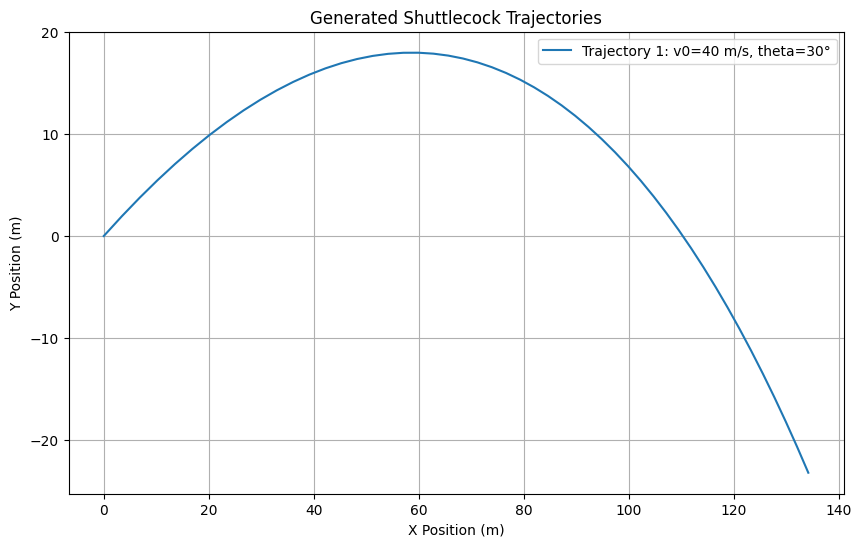

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Constants for trajectory simulation
g = 9.81  # Gravity (m/s^2)
b = 0.1  # Air resistance coefficient
time_step = 0.1  # Time step for simulation

class GenDataEquations:
    def __init__(self, v_initial=30, theta_initial=30):
        """
        Initialize the data generation equations for the shuttlecock trajectory.

        Parameters:
        v_initial (float): Initial velocity of the shuttlecock (m/s).
        theta_initial (float): Launch angle of the shuttlecock (degrees).
        """
        self.theta_initial = np.radians(theta_initial)
        self.v_x0 = v_initial * np.cos(self.theta_initial)
        self.v_y0 = v_initial * np.sin(self.theta_initial)

    def calculate_position(self, t):
        """
        Calculate the position (x, y) at time t.

        Parameters:
        t (float or np.ndarray): Time (s).

        Returns:
        tuple: (x, y) positions at time t.
        """
        x = (self.v_x0 / b) * (1 - np.exp(-b * t))
        y = (1 / b) * ((self.v_y0 + g / b) * (1 - np.exp(-b * t)) - (g * t))
        return x, y

    def generate_trajectory(self, total_time):
        """
        Generate the trajectory data over a specified total time.

        Parameters:
        total_time (float): Total simulation time (s).

        Returns:
        tuple: (t, x, y) arrays representing the trajectory.
        """
        t = np.arange(0, total_time, time_step)
        x, y = self.calculate_position(t)
        return t, x, y

# Generate multiple trajectories
conditions = [
    {"v_initial": 40, "theta_initial": 30},  # Valid because v_initial > 30 m/s for 30°
    # {"v_initial": 25, "theta_initial": 30},  # Valid
    # {"v_initial": 55, "theta_initial": 30},  # Valid because v_initial < 56 m/s
    # {"v_initial": 35, "theta_initial": 30},  # Valid because v_initial > 30 m/s for 30°
]

data = []
for condition in conditions:
    generator = GenDataEquations(v_initial=condition["v_initial"], theta_initial=condition["theta_initial"])
    t, x, y = generator.generate_trajectory(total_time=5)  # Fixed total time of 5 seconds
    data.append((t, x, y))

# Visualize all trajectories
plt.figure(figsize=(10, 6))
for i, (t, x, y) in enumerate(data):
    plt.plot(x, y, label=f"Trajectory {i+1}: v0={conditions[i]['v_initial']} m/s, theta={conditions[i]['theta_initial']}°")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Generated Shuttlecock Trajectories")
plt.grid()
plt.legend()
plt.show()

# Combine data for training
all_t = np.concatenate([t for t, _, _ in data])
all_x = np.concatenate([x for _, x, _ in data])
all_y = np.concatenate([y for _, _, y in data])

# Custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, t, x, y):
        # Remove NaN entries
        valid_indices = ~np.isnan(x) & ~np.isnan(y)
        self.t = torch.tensor(t[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.x = torch.tensor(x[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y[valid_indices], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx], self.y[idx]

# Create dataset and dataloader
dataset = TrajectoryDataset(all_t, all_x, all_y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the PiNN model
class PiNN(nn.Module):
    def __init__(self):
        super(PiNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output x, y, v_x, v_y 
        )

    def forward(self, t):
        return self.model(t)

# Initialize model, loss, and optimizer
model = PiNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=1000):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(t_batch)
            loss = criterion(predictions[:, 0], x_batch.squeeze()) + \
                   criterion(predictions[:, 1], y_batch.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

In [5]:
import imageio

# Training loop with video frame saving
def train_model_with_video(model, dataloader, criterion, optimizer, epochs=1000, save_interval=50):
    frames = []  # To store file paths of saved images
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(t_batch)
            loss = criterion(predictions[:, 0], x_batch.squeeze()) + \
                   criterion(predictions[:, 1], y_batch.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Save a frame every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            t_test = np.linspace(0, 5, 100)
            predictions = predict_trajectory(model, t_test)

            plt.figure(figsize=(10, 6))
            plt.plot(all_x, all_y, label="True Trajectories", marker="o")
            plt.plot(predictions[:, 0], predictions[:, 1], label=f"Predicted Trajectory (Epoch {epoch+1})", linestyle="--")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.title(f"Trajectory Prediction (Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f})")
            plt.grid()
            plt.legend()

            frame_path = f"frame_{epoch + 1:04d}.png"
            plt.savefig(frame_path)
            plt.close()
            frames.append(frame_path)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Create video from saved frames
    video_path = "training_video.mp4"
    with imageio.get_writer(video_path, fps=2) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    print(f"Video saved as {video_path}")

# Train the model and generate video
train_model_with_video(model, dataloader, criterion, optimizer, epochs=1000)


Epoch 1/1000, Loss: 179.7602
Epoch 2/1000, Loss: 188.8031
Epoch 3/1000, Loss: 171.8879
Epoch 4/1000, Loss: 181.0064
Epoch 5/1000, Loss: 181.3164
Epoch 6/1000, Loss: 133.3321
Epoch 7/1000, Loss: 174.4802
Epoch 8/1000, Loss: 151.9555
Epoch 9/1000, Loss: 193.5171
Epoch 10/1000, Loss: 168.8160
Epoch 11/1000, Loss: 140.0417
Epoch 12/1000, Loss: 148.9884
Epoch 13/1000, Loss: 145.5547
Epoch 14/1000, Loss: 141.4173
Epoch 15/1000, Loss: 130.0690
Epoch 16/1000, Loss: 133.7006
Epoch 17/1000, Loss: 125.4327
Epoch 18/1000, Loss: 221.0355
Epoch 19/1000, Loss: 143.8418
Epoch 20/1000, Loss: 130.3409
Epoch 21/1000, Loss: 173.4330
Epoch 22/1000, Loss: 137.0802
Epoch 23/1000, Loss: 157.0392
Epoch 24/1000, Loss: 134.3663
Epoch 25/1000, Loss: 152.2284
Epoch 26/1000, Loss: 120.0213
Epoch 27/1000, Loss: 139.7900
Epoch 28/1000, Loss: 123.0777
Epoch 29/1000, Loss: 117.4747
Epoch 30/1000, Loss: 127.3723
Epoch 31/1000, Loss: 107.7825
Epoch 32/1000, Loss: 133.2076
Epoch 33/1000, Loss: 125.0008
Epoch 34/1000, Loss

C:\Users\THiNKBooK\AppData\Local\Temp\ipykernel_4324\1223056576.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 600) to (1008, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as training_video.mp4


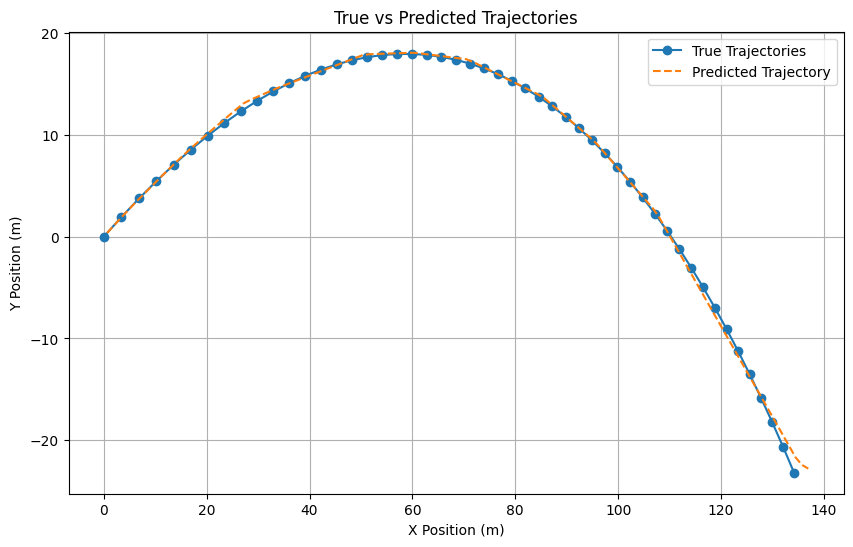

In [6]:
# Make predictions with the trained model
def predict_trajectory(model, t_values):
    model.eval()
    with torch.no_grad():
        t_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(1)
        predictions = model(t_tensor)
    return predictions.numpy()

# Generate new time values for prediction
t_test = np.linspace(0, 5, 100)
predictions = predict_trajectory(model, t_test)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(all_x, all_y, label="True Trajectories", marker="o")
plt.plot(predictions[:, 0], predictions[:, 1], label="Predicted Trajectory", linestyle="--")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("True vs Predicted Trajectories")
plt.grid()
plt.legend()
plt.show()

# PiNN precting shuttlecock trjectory

In [54]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Constants for physics-based loss
g = 9.81  # gravitational constant (m/s^2)
b = 0.05  # drag coefficient (m/s)
m = 0.1   # mass of the shuttlecock (kg)

# Data generation class
class GenDataEquations:
    def __init__(self, v_initial=40, theta_initial=30):
        self.theta_initial = np.radians(theta_initial)
        self.v_x0 = v_initial * np.cos(self.theta_initial)
        self.v_y0 = v_initial * np.sin(self.theta_initial)

    def calculate_position(self, t):
        x = (self.v_x0 / b) * (1 - np.exp(-b * t))
        y = (1 / b) * ((self.v_y0 + g / b) * (1 - np.exp(-b * t)) - (g * t))
        return x, y

    def generate_trajectory(self, total_time):
        t = np.arange(0, total_time, 0.1)
        x, y = self.calculate_position(t)
        return t, x, y

# Known data points
known_time_points = np.array([0, 1, 2, 3, 3.5, 4.1])
generator = GenDataEquations(v_initial=40, theta_initial=30)
full_t, full_x, full_y = generator.generate_trajectory(total_time=5)
known_x, known_y = generator.calculate_position(known_time_points)

# Neural Network Model
class PiNN(nn.Module):
    def __init__(self):
        super(PiNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # Output: x, y

    def forward(self, t):
        x = torch.relu(self.fc1(t))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Loss functions
def physics_based_loss(predictions, t):
    x_pred, y_pred = predictions[:, 0], predictions[:, 1]
    dt = t[1] - t[0]  # Assumes uniform spacing

    # Finite differences for velocities
    v_x_pred = torch.diff(x_pred, append=x_pred[-1:]) / dt
    v_y_pred = torch.diff(y_pred, append=y_pred[-1:]) / dt

    # Vertical motion loss: m * d^2y/dt^2 + b * v_y^2 - mg = 0
    vertical_loss = torch.mean((m * v_y_pred**2 + b * v_y_pred**2 - m * g) ** 2)

    # Horizontal motion loss: m * d^2x/dt^2 + b * v_x^2 = 0
    horizontal_loss = torch.mean((m * v_x_pred**2 + b * v_x_pred**2) ** 2)

    # Combine and normalize physics loss
    physics_loss = vertical_loss + horizontal_loss
    return physics_loss / 1000  # Adjust the scaling factor empirically

def data_based_loss(predictions, known_x, known_y):
    x_pred, y_pred = predictions[:, 0], predictions[:, 1]
    return torch.mean((x_pred - known_x) ** 2 + (y_pred - known_y) ** 2)


- The loss backpropagation need tuning, which i could make time to for this current state.

Epoch [10/500], Data Loss: 1028.9168701171875, Physics Loss: 0.022851882502436638, Total Loss: 1028.9171142578125
Epoch [20/500], Data Loss: 654.8395385742188, Physics Loss: 0.09225450456142426, Total Loss: 654.8404541015625
Epoch [30/500], Data Loss: 527.2513427734375, Physics Loss: 0.12263768911361694, Total Loss: 527.2525634765625
Epoch [40/500], Data Loss: 420.6231384277344, Physics Loss: 0.20803506672382355, Total Loss: 420.6252136230469
Epoch [50/500], Data Loss: 378.705078125, Physics Loss: 0.22681546211242676, Total Loss: 378.70733642578125
Epoch [60/500], Data Loss: 359.421630859375, Physics Loss: 0.2415858805179596, Total Loss: 359.4240417480469
Epoch [70/500], Data Loss: 287.1202697753906, Physics Loss: 0.3689909279346466, Total Loss: 287.12396240234375
Epoch [80/500], Data Loss: 279.5205383300781, Physics Loss: 0.313197523355484, Total Loss: 279.523681640625
Epoch [90/500], Data Loss: 247.4075469970703, Physics Loss: 0.22890125215053558, Total Loss: 247.4098358154297
Epoch 

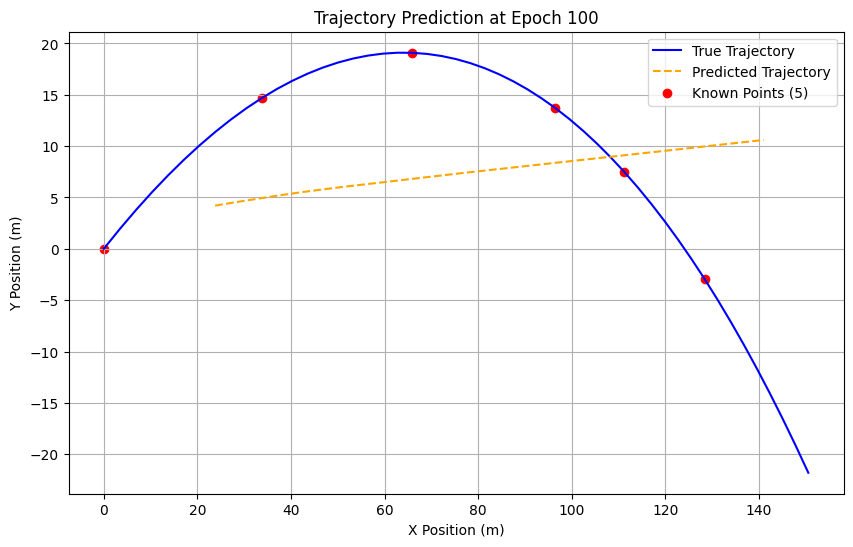

Epoch [110/500], Data Loss: 192.24693298339844, Physics Loss: 0.5206831693649292, Total Loss: 192.25213623046875
Epoch [120/500], Data Loss: 160.55345153808594, Physics Loss: 0.6456232666969299, Total Loss: 160.55990600585938
Epoch [130/500], Data Loss: 159.2389678955078, Physics Loss: 0.5543841123580933, Total Loss: 159.2445068359375
Epoch [140/500], Data Loss: 159.6472625732422, Physics Loss: 0.6156894564628601, Total Loss: 159.65341186523438
Epoch [150/500], Data Loss: 139.62254333496094, Physics Loss: 0.7001744508743286, Total Loss: 139.62954711914062
Epoch [160/500], Data Loss: 138.72193908691406, Physics Loss: 0.680522620677948, Total Loss: 138.72874450683594
Epoch [170/500], Data Loss: 221.6982421875, Physics Loss: 0.4431135654449463, Total Loss: 221.70266723632812
Epoch [180/500], Data Loss: 232.2462615966797, Physics Loss: 0.396737277507782, Total Loss: 232.25022888183594


KeyboardInterrupt: 

In [53]:
# Training
model = PiNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 500
lambda_data = 10.0  # Stronger weight for data loss
lambda_physics = 1.0  # Physics loss weight


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Training over batches
    for t_batch, x_batch, y_batch, _ in DataLoader(
        TrajectoryDataset(full_t, full_x, full_y, known_time_points, known_x, known_y), batch_size=16, shuffle=True
    ):
        optimizer.zero_grad()
        
        # Predictions
        predictions = model(t_batch)

        # Calculate physics-based loss
        physics_loss = physics_based_loss(predictions, t_batch)

        # Always calculate data loss for the 5 known points
        known_t_tensor = torch.tensor(known_time_points, dtype=torch.float32).unsqueeze(1)
        known_x_tensor = torch.tensor(known_x, dtype=torch.float32)
        known_y_tensor = torch.tensor(known_y, dtype=torch.float32)

        known_predictions = model(known_t_tensor)
        data_loss = data_based_loss(known_predictions, known_x_tensor, known_y_tensor)

        # Total loss
        total_loss = lambda_data * data_loss + lambda_physics * physics_loss
        total_loss.backward()
        optimizer.step()

    # Logging
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Data Loss: {data_loss.item()}, Physics Loss: {physics_loss.item()}, Total Loss: {total_loss.item()}")

    # Plot predictions every 100 epochs
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            full_t_tensor = torch.tensor(full_t, dtype=torch.float32).unsqueeze(1)
            predictions = model(full_t_tensor)
            x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

            # Plot
            plt.figure(figsize=(10, 6))
            plt.plot(full_x, full_y, label="True Trajectory", color="blue")
            plt.plot(x_pred, y_pred, label="Predicted Trajectory", linestyle="--", color="orange")
            plt.scatter(known_x, known_y, color="red", label="Known Points (5)")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.title(f"Trajectory Prediction at Epoch {epoch + 1}")
            plt.legend()
            plt.grid()
            plt.show()


# End